In [8]:
pip install pandas numpy statsmodels yfinance matplotlib

Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
Top 8 pairs based on Engle-Granger test:
Pair 1: ('AMZN', 'AVGO')
Pair 2: ('AMZN', 'COST')
Pair 3: ('AMZN', 'GOOGL')
Pair 4: ('AMZN', 'HD')
Pair 5: ('AMZN', 'JNJ')
Pair 6: ('AMZN', 'JPM')
Pair 7: ('AMZN', 'LLY')
Pair 8: ('AMZN', 'MA')


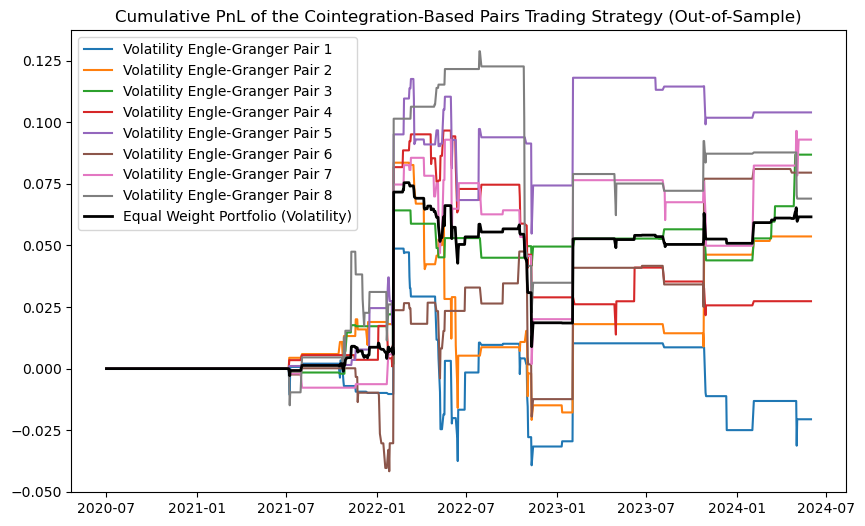

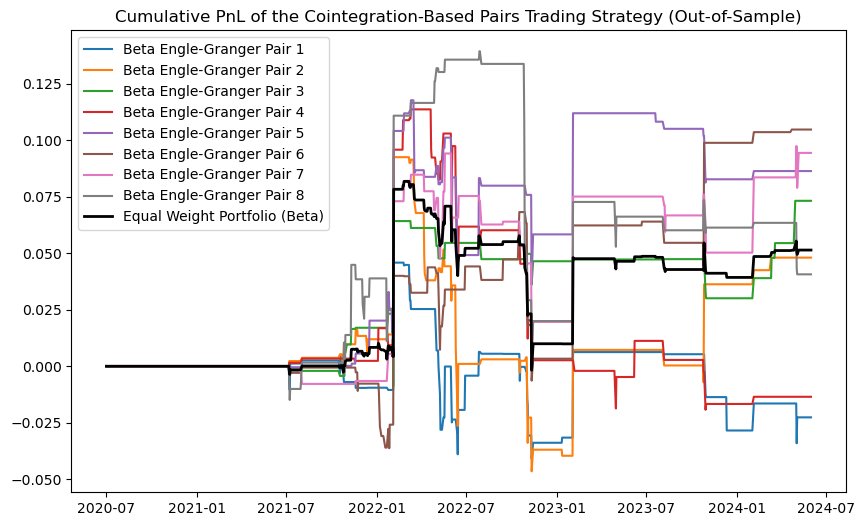

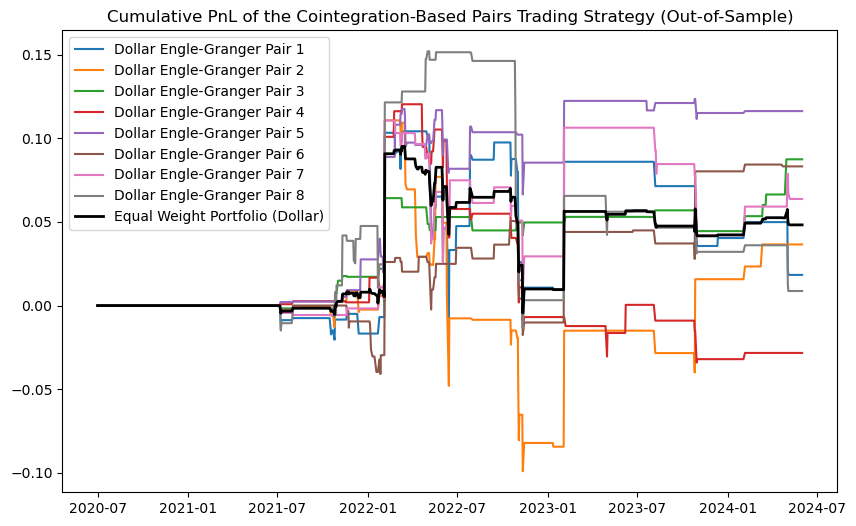

Cumulative PnL (Volatility Engle-Granger Pair 1): -0.02
Cumulative PnL (Volatility Engle-Granger Pair 2): 0.05
Cumulative PnL (Volatility Engle-Granger Pair 3): 0.09
Cumulative PnL (Volatility Engle-Granger Pair 4): 0.03
Cumulative PnL (Volatility Engle-Granger Pair 5): 0.10
Cumulative PnL (Volatility Engle-Granger Pair 6): 0.08
Cumulative PnL (Volatility Engle-Granger Pair 7): 0.09
Cumulative PnL (Volatility Engle-Granger Pair 8): 0.07
Cumulative PnL (Equal Weight Portfolio - Volatility): 0.06
Cumulative PnL (Beta Engle-Granger Pair 1): -0.02
Cumulative PnL (Beta Engle-Granger Pair 2): 0.05
Cumulative PnL (Beta Engle-Granger Pair 3): 0.07
Cumulative PnL (Beta Engle-Granger Pair 4): -0.01
Cumulative PnL (Beta Engle-Granger Pair 5): 0.09
Cumulative PnL (Beta Engle-Granger Pair 6): 0.10
Cumulative PnL (Beta Engle-Granger Pair 7): 0.09
Cumulative PnL (Beta Engle-Granger Pair 8): 0.04
Cumulative PnL (Equal Weight Portfolio - Beta): 0.05
Cumulative PnL (Dollar Engle-Granger Pair 1): 0.02
Cu

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from itertools import combinations
import statsmodels.api as sm

# Define the tickers for demonstration (excluding S&P 500 index)
tickers = ["MSFT", "NVDA", "AAPL", "AMZN", "META", "GOOGL", "AVGO", "LLY", "JPM", "XOM", "TSLA", "UNH", "V", "PG", "COST", "MA", "JNJ", "HD"]

start_date = '2013-01-01'
end_date = '2024-06-01'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(data).diff().dropna()
sp500_log_returns = np.log(sp500).diff().dropna()

# Normalize log returns
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Ensure no NaNs or infinite values
assert not normalized_log_returns.isnull().values.any(), "Log returns data contains NaN values"
assert np.isfinite(normalized_log_returns.values).all(), "Log returns data contains infinite values"

# Function to test cointegration for a pair using Engle-Granger test
def engle_granger_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    score, pvalue, _ = coint(log_ret_pair.iloc[:, 0], log_ret_pair.iloc[:, 1])
    return pvalue, pair

# Split the data into in-sample and out-of-sample
split_date = '2020-07-01'
in_sample_data = normalized_log_returns[:split_date]
out_sample_data = normalized_log_returns[split_date:]

# Get all possible pairs
pairs = list(combinations(in_sample_data.columns, 2))

# Test cointegration for all pairs using in-sample data
engle_granger_results = [engle_granger_cointegration_test(pair, in_sample_data) for pair in pairs]

# Sort and select the top 8 pairs based on Engle-Granger test
engle_granger_results.sort(key=lambda x: x[0])
top_pairs_engle_granger = engle_granger_results[:8]

# Output the selected pairs for Engle-Granger method
print("Top 8 pairs based on Engle-Granger test:")
for i, pair in enumerate(top_pairs_engle_granger):
    print(f"Pair {i+1}: {pair[1]}")

# Function to calculate beta relative to a benchmark
def calculate_beta(stock_returns, benchmark_returns):
    X = sm.add_constant(stock_returns)
    model = sm.OLS(benchmark_returns, X).fit()
    return model.params[1]  # Beta coefficient

# Parameters for entry, exit, and stop-loss
entry_threshold = 2
exit_threshold = 0.5
stop_loss_threshold = 2.5

# Calculate the spreads, Z-scores, and positions for the top pairs
def calculate_spreads_and_positions(top_pairs, in_sample_data, out_sample_data, benchmark_returns):
    spreads = []
    z_scores = []
    positions_volatility = []
    positions_beta = []
    positions_dollar = []
    for result in top_pairs:
        beta, _ = np.polyfit(in_sample_data[result[1][0]], in_sample_data[result[1][1]], 1)
        spread = in_sample_data[result[1][0]] - beta * in_sample_data[result[1][1]]
        spread_out_sample = out_sample_data[result[1][0]] - beta * out_sample_data[result[1][1]]

        spreads.append(spread)

        spread_mean = spread_out_sample.rolling(window=252).mean()
        spread_std = spread_out_sample.rolling(window=252).std()
        z_score = (spread_out_sample - spread_mean) / spread_std
        z_scores.append(z_score)

        # Calculate position sizes for volatility, beta, and dollar neutrality
        volatility_stock1 = in_sample_data[result[1][0]].std()
        volatility_stock2 = in_sample_data[result[1][1]].std()
        position_ratio_stock1_vol = 1 / volatility_stock1
        position_ratio_stock2_vol = 1 / volatility_stock2
        total_ratio_vol = position_ratio_stock1_vol + position_ratio_stock2_vol
        position_ratio_stock1_vol /= total_ratio_vol
        position_ratio_stock2_vol /= total_ratio_vol

        beta_stock1 = calculate_beta(log_returns[result[1][0]], benchmark_returns)
        beta_stock2 = calculate_beta(log_returns[result[1][1]], benchmark_returns)
        position_ratio_stock1_beta = 1 / beta_stock1
        position_ratio_stock2_beta = 1 / beta_stock2
        total_ratio_beta = position_ratio_stock1_beta + position_ratio_stock2_beta
        position_ratio_stock1_beta /= total_ratio_beta
        position_ratio_stock2_beta /= total_ratio_beta

        price_stock1 = data[result[1][0]].iloc[-1]  # Most recent price
        price_stock2 = data[result[1][1]].iloc[-1]  # Most recent price
        investment_amount = 10000  # Example investment amount per stock
        shares_stock1 = investment_amount / price_stock1
        shares_stock2 = investment_amount / price_stock2
        total_shares = shares_stock1 + shares_stock2
        position_ratio_stock1_dollar = shares_stock1 / total_shares
        position_ratio_stock2_dollar = shares_stock2 / total_shares

        def generate_positions(z_score, position_ratio_stock1, position_ratio_stock2):
            positions = []
            entry_dates = []
            exit_dates = []
            stop_loss_dates = []
            initial_entry_z_score = None
            for i in range(len(z_score)):
                if positions and any(positions[-1]):
                    if initial_entry_z_score is None:
                        initial_entry_z_score = z_score[i]
                    if abs(z_score[i] - initial_entry_z_score) >= stop_loss_threshold:
                        positions.append([0, 0])
                        initial_entry_z_score = None
                        stop_loss_dates.append(z_score.index[i])
                        continue
                
                if z_score[i] > entry_threshold:
                    positions.append([-position_ratio_stock1, position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif z_score[i] < -entry_threshold:
                    positions.append([position_ratio_stock1, -position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif abs(z_score[i]) < exit_threshold:
                    positions.append([0, 0])
                    exit_dates.append(z_score.index[i])
                    initial_entry_z_score = None
                else:
                    positions.append(positions[-1] if positions else [0, 0])
            return positions, entry_dates, exit_dates, stop_loss_dates

        positions_volatility.append(generate_positions(z_score, position_ratio_stock1_vol, position_ratio_stock2_vol))
        positions_beta.append(generate_positions(z_score, position_ratio_stock1_beta, position_ratio_stock2_beta))
        positions_dollar.append(generate_positions(z_score, position_ratio_stock1_dollar, position_ratio_stock2_dollar))

    return spreads, z_scores, positions_volatility, positions_beta, positions_dollar

# Calculate spreads and positions for Engle-Granger method
spreads_engle_granger, z_scores_engle_granger, positions_volatility_engle_granger, positions_beta_engle_granger, positions_dollar_engle_granger = calculate_spreads_and_positions(
    top_pairs_engle_granger, in_sample_data, out_sample_data, sp500_log_returns)

# Convert positions to DataFrames and align indexes
positions_volatility_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_volatility_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]
positions_beta_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_beta_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]
positions_dollar_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_dollar_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]

# Calculate daily returns of the selected pairs
selected_pairs = [pair[1] for pair in top_pairs_engle_granger]
returns_out_sample = log_returns.loc[split_date:][list(set([item for sublist in selected_pairs for item in sublist]))].dropna()

# Calculate daily PnL for each method and each neutrality
def calculate_daily_pnl(positions_dfs, returns_out_sample, selected_pairs):
    daily_pnls = []
    for pos_df, pair in zip(positions_dfs, selected_pairs):
        daily_pnl = (pos_df.shift(1) * returns_out_sample[[pair[0], pair[1]]]).sum(axis=1)
        daily_pnls.append(daily_pnl)
    return daily_pnls

daily_pnls_volatility_engle_granger = calculate_daily_pnl(positions_volatility_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])
daily_pnls_beta_engle_granger = calculate_daily_pnl(positions_beta_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])
daily_pnls_dollar_engle_granger = calculate_daily_pnl(positions_dollar_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])

# Calculate cumulative PnL for each method and each neutrality
def calculate_cumulative_pnl(daily_pnls):
    return [daily_pnl.cumsum() for daily_pnl in daily_pnls]

cumulative_pnls_volatility_engle_granger = calculate_cumulative_pnl(daily_pnls_volatility_engle_granger)
cumulative_pnls_beta_engle_granger = calculate_cumulative_pnl(daily_pnls_beta_engle_granger)
cumulative_pnls_dollar_engle_granger = calculate_cumulative_pnl(daily_pnls_dollar_engle_granger)

# Calculate equal weight portfolio PnL
total_daily_pnl_volatility = sum(daily_pnls_volatility_engle_granger) / len(daily_pnls_volatility_engle_granger)
total_daily_pnl_beta = sum(daily_pnls_beta_engle_granger) / len(daily_pnls_beta_engle_granger)
total_daily_pnl_dollar = sum(daily_pnls_dollar_engle_granger) / len(daily_pnls_dollar_engle_granger)

cumulative_pnl_portfolio_volatility = total_daily_pnl_volatility.cumsum()
cumulative_pnl_portfolio_beta = total_daily_pnl_beta.cumsum()
cumulative_pnl_portfolio_dollar = total_daily_pnl_dollar.cumsum()

# Plot cumulative PnL for each method and the portfolio
plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_volatility_engle_granger):
    plt.plot(cumulative_pnl, label=f'Volatility Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_volatility, label='Equal Weight Portfolio (Volatility)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_beta_engle_granger):
    plt.plot(cumulative_pnl, label=f'Beta Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_beta, label='Equal Weight Portfolio (Beta)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_dollar_engle_granger):
    plt.plot(cumulative_pnl, label=f'Dollar Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_dollar, label='Equal Weight Portfolio (Dollar)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

# Print cumulative PnL for each method and the portfolio
def print_cumulative_pnls(cumulative_pnls, method):
    for i, cumulative_pnl in enumerate(cumulative_pnls):
        print(f"Cumulative PnL ({method} Pair {i+1}): {cumulative_pnl.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_volatility_engle_granger, 'Volatility Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Volatility): {cumulative_pnl_portfolio_volatility.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_beta_engle_granger, 'Beta Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Beta): {cumulative_pnl_portfolio_beta.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_dollar_engle_granger, 'Dollar Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Dollar): {cumulative_pnl_portfolio_dollar.iloc[-1]:.2f}")

# Print strategy performance metrics for each method
def print_performance_metrics(cumulative_pnl, daily_pnl):
    total_return = cumulative_pnl.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(cumulative_pnl)) - 1  # Assuming 252 trading days in a year
    annualized_volatility = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_volatility_engle_granger, daily_pnls_volatility_engle_granger)):
    print(f"Performance Metrics (Volatility Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Volatility):")
print_performance_metrics(cumulative_pnl_portfolio_volatility, total_daily_pnl_volatility)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_beta_engle_granger, daily_pnls_beta_engle_granger)):
    print(f"Performance Metrics (Beta Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Beta):")
print_performance_metrics(cumulative_pnl_portfolio_beta, total_daily_pnl_beta)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_dollar_engle_granger, daily_pnls_dollar_engle_granger)):
    print(f"Performance Metrics (Dollar Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Dollar):")
print_performance_metrics(cumulative_pnl_portfolio_dollar, total_daily_pnl_dollar)


[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
Top 8 pairs based on Johansen test:
Pair 1: ('AAPL', 'AMZN')
Pair 2: ('AAPL', 'AVGO')
Pair 3: ('AAPL', 'COST')
Pair 4: ('AAPL', 'GOOGL')
Pair 5: ('AAPL', 'HD')
Pair 6: ('AAPL', 'JNJ')
Pair 7: ('AAPL', 'JPM')
Pair 8: ('AAPL', 'LLY')


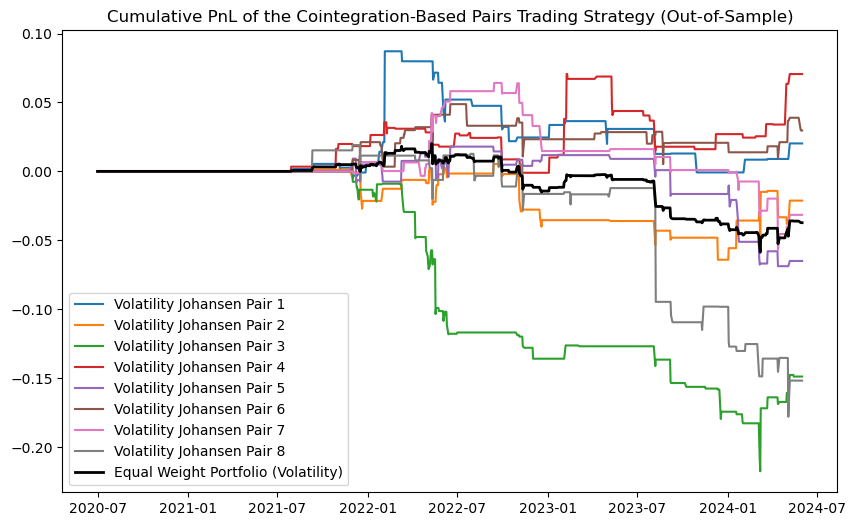

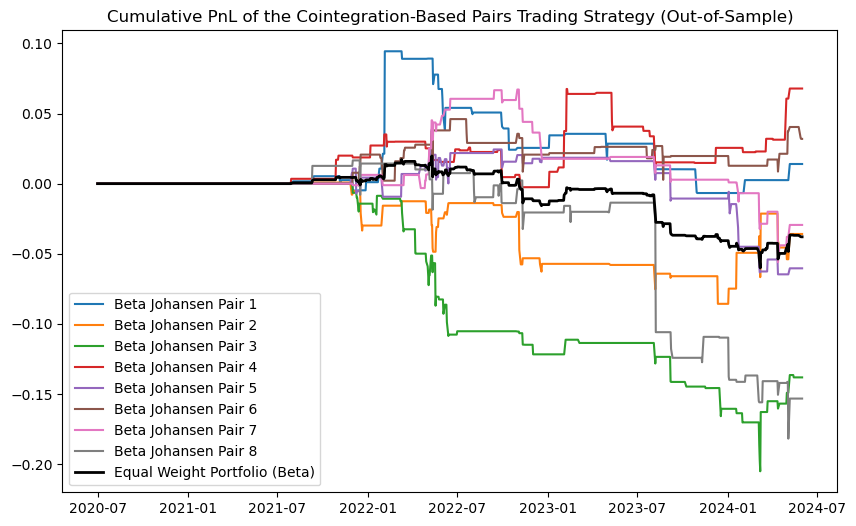

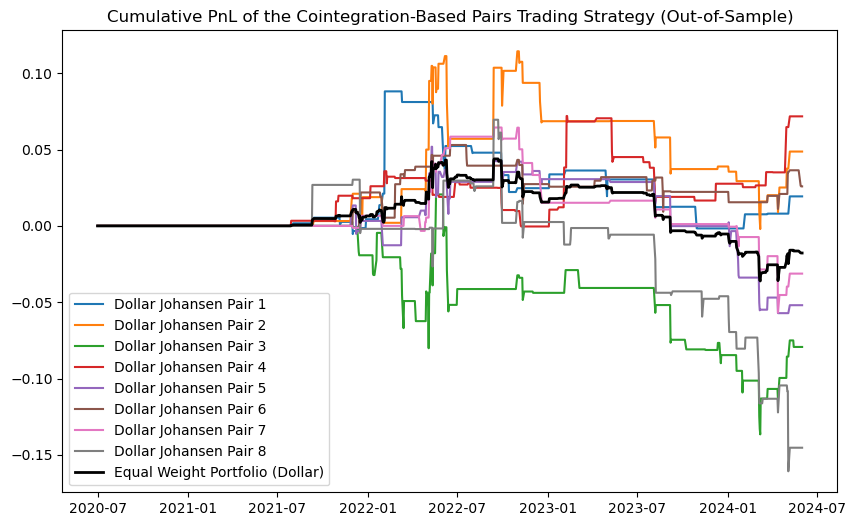

Cumulative PnL (Volatility Johansen Pair 1): 0.02
Cumulative PnL (Volatility Johansen Pair 2): -0.02
Cumulative PnL (Volatility Johansen Pair 3): -0.15
Cumulative PnL (Volatility Johansen Pair 4): 0.07
Cumulative PnL (Volatility Johansen Pair 5): -0.07
Cumulative PnL (Volatility Johansen Pair 6): 0.03
Cumulative PnL (Volatility Johansen Pair 7): -0.03
Cumulative PnL (Volatility Johansen Pair 8): -0.15
Cumulative PnL (Equal Weight Portfolio - Volatility): -0.04
Cumulative PnL (Beta Johansen Pair 1): 0.01
Cumulative PnL (Beta Johansen Pair 2): -0.04
Cumulative PnL (Beta Johansen Pair 3): -0.14
Cumulative PnL (Beta Johansen Pair 4): 0.07
Cumulative PnL (Beta Johansen Pair 5): -0.06
Cumulative PnL (Beta Johansen Pair 6): 0.03
Cumulative PnL (Beta Johansen Pair 7): -0.03
Cumulative PnL (Beta Johansen Pair 8): -0.15
Cumulative PnL (Equal Weight Portfolio - Beta): -0.04
Cumulative PnL (Dollar Johansen Pair 1): 0.02
Cumulative PnL (Dollar Johansen Pair 2): 0.05
Cumulative PnL (Dollar Johansen 

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations
import statsmodels.api as sm

# Define the tickers for demonstration (excluding S&P 500 index)
tickers = ["MSFT", "NVDA", "AAPL", "AMZN", "META", "GOOGL", "AVGO", "LLY", "JPM", "XOM", "TSLA", "UNH", "V", "PG", "COST", "MA", "JNJ", "HD"]

start_date = '2013-01-01'
end_date = '2024-06-01'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(data).diff().dropna()
sp500_log_returns = np.log(sp500).diff().dropna()

# Normalize log returns
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Ensure no NaNs or infinite values
assert not normalized_log_returns.isnull().values.any(), "Log returns data contains NaN values"
assert np.isfinite(normalized_log_returns.values).all(), "Log returns data contains infinite values"

# Function to test cointegration for a pair using Johansen test
def johansen_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    johansen_test = coint_johansen(log_ret_pair, det_order=0, k_ar_diff=1)
    trace_statistic = johansen_test.lr1
    critical_values = johansen_test.cvt[:, 1]  # 5% critical values
    num_cointegrating_relations = sum(trace_statistic > critical_values)
    cointegration_vectors = johansen_test.evec if num_cointegrating_relations > 0 else None
    return num_cointegrating_relations, pair, cointegration_vectors

# Split the data into in-sample and out-of-sample
split_date = '2020-07-01'
in_sample_data = normalized_log_returns[:split_date]
out_sample_data = normalized_log_returns[split_date:]

# Get all possible pairs
pairs = list(combinations(in_sample_data.columns, 2))

# Test cointegration for all pairs using in-sample data
johansen_results = [johansen_cointegration_test(pair, in_sample_data) for pair in pairs]

# Sort and select the top 8 pairs based on Johansen test
johansen_results.sort(reverse=True, key=lambda x: x[0])
top_pairs_johansen = johansen_results[:8]

# Output the selected pairs for Johansen method
print("Top 8 pairs based on Johansen test:")
for i, pair in enumerate(top_pairs_johansen):
    print(f"Pair {i+1}: {pair[1]}")

# Function to calculate beta relative to a benchmark
def calculate_beta(stock_returns, benchmark_returns):
    X = sm.add_constant(stock_returns)
    model = sm.OLS(benchmark_returns, X).fit()
    return model.params[1]  # Beta coefficient

# Parameters for entry, exit, and stop-loss
entry_threshold = 2
exit_threshold = 0.5
stop_loss_threshold = 2.5

# Calculate the spreads, Z-scores, and positions for the top pairs
def calculate_spreads_and_positions(top_pairs, in_sample_data, out_sample_data, benchmark_returns):
    spreads = []
    z_scores = []
    positions_volatility = []
    positions_beta = []
    positions_dollar = []
    for result in top_pairs:
        cointegration_vector = result[2][:, 0]
        spread = in_sample_data[result[1][0]] * cointegration_vector[0] - in_sample_data[result[1][1]] * cointegration_vector[1]
        spread_out_sample = out_sample_data[result[1][0]] * cointegration_vector[0] - out_sample_data[result[1][1]] * cointegration_vector[1]

        spreads.append(spread)

        spread_mean = spread_out_sample.rolling(window=252).mean()
        spread_std = spread_out_sample.rolling(window=252).std()
        z_score = (spread_out_sample - spread_mean) / spread_std
        z_scores.append(z_score)

        # Calculate position sizes for volatility, beta, and dollar neutrality
        volatility_stock1 = in_sample_data[result[1][0]].std()
        volatility_stock2 = in_sample_data[result[1][1]].std()
        position_ratio_stock1_vol = 1 / volatility_stock1
        position_ratio_stock2_vol = 1 / volatility_stock2
        total_ratio_vol = position_ratio_stock1_vol + position_ratio_stock2_vol
        position_ratio_stock1_vol /= total_ratio_vol
        position_ratio_stock2_vol /= total_ratio_vol

        beta_stock1 = calculate_beta(log_returns[result[1][0]], benchmark_returns)
        beta_stock2 = calculate_beta(log_returns[result[1][1]], benchmark_returns)
        position_ratio_stock1_beta = 1 / beta_stock1
        position_ratio_stock2_beta = 1 / beta_stock2
        total_ratio_beta = position_ratio_stock1_beta + position_ratio_stock2_beta
        position_ratio_stock1_beta /= total_ratio_beta
        position_ratio_stock2_beta /= total_ratio_beta

        price_stock1 = data[result[1][0]].iloc[-1]  # Most recent price
        price_stock2 = data[result[1][1]].iloc[-1]  # Most recent price
        investment_amount = 10000  # Example investment amount per stock
        shares_stock1 = investment_amount / price_stock1
        shares_stock2 = investment_amount / price_stock2
        total_shares = shares_stock1 + shares_stock2
        position_ratio_stock1_dollar = shares_stock1 / total_shares
        position_ratio_stock2_dollar = shares_stock2 / total_shares

        def generate_positions(z_score, position_ratio_stock1, position_ratio_stock2):
            positions = []
            entry_dates = []
            exit_dates = []
            stop_loss_dates = []
            initial_entry_z_score = None
            for i in range(len(z_score)):
                if positions and any(positions[-1]):
                    if initial_entry_z_score is None:
                        initial_entry_z_score = z_score[i]
                    if abs(z_score[i] - initial_entry_z_score) >= stop_loss_threshold:
                        positions.append([0, 0])
                        initial_entry_z_score = None
                        stop_loss_dates.append(z_score.index[i])
                        continue
                
                if z_score[i] > entry_threshold:
                    positions.append([-position_ratio_stock1, position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif z_score[i] < -entry_threshold:
                    positions.append([position_ratio_stock1, -position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif abs(z_score[i]) < exit_threshold:
                    positions.append([0, 0])
                    exit_dates.append(z_score.index[i])
                    initial_entry_z_score = None
                else:
                    positions.append(positions[-1] if positions else [0, 0])
            return positions, entry_dates, exit_dates, stop_loss_dates

        positions_volatility.append(generate_positions(z_score, position_ratio_stock1_vol, position_ratio_stock2_vol))
        positions_beta.append(generate_positions(z_score, position_ratio_stock1_beta, position_ratio_stock2_beta))
        positions_dollar.append(generate_positions(z_score, position_ratio_stock1_dollar, position_ratio_stock2_dollar))

    return spreads, z_scores, positions_volatility, positions_beta, positions_dollar

# Calculate spreads and positions for Johansen method
spreads_johansen, z_scores_johansen, positions_volatility_johansen, positions_beta_johansen, positions_dollar_johansen = calculate_spreads_and_positions(
    top_pairs_johansen, in_sample_data, out_sample_data, sp500_log_returns)

# Convert positions to DataFrames and align indexes
positions_volatility_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_volatility_johansen, z_scores_johansen, top_pairs_johansen)]
positions_beta_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_beta_johansen, z_scores_johansen, top_pairs_johansen)]
positions_dollar_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_dollar_johansen, z_scores_johansen, top_pairs_johansen)]

# Calculate daily returns of the selected pairs
selected_pairs = [pair[1] for pair in top_pairs_johansen]
returns_out_sample = log_returns.loc[split_date:][list(set([item for sublist in selected_pairs for item in sublist]))].dropna()

# Calculate daily PnL for each method and each neutrality
def calculate_daily_pnl(positions_dfs, returns_out_sample, selected_pairs):
    daily_pnls = []
    for pos_df, pair in zip(positions_dfs, selected_pairs):
        daily_pnl = (pos_df.shift(1) * returns_out_sample[[pair[0], pair[1]]]).sum(axis=1)
        daily_pnls.append(daily_pnl)
    return daily_pnls

daily_pnls_volatility_johansen = calculate_daily_pnl(positions_volatility_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])
daily_pnls_beta_johansen = calculate_daily_pnl(positions_beta_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])
daily_pnls_dollar_johansen = calculate_daily_pnl(positions_dollar_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])

# Calculate cumulative PnL for each method and each neutrality
def calculate_cumulative_pnl(daily_pnls):
    return [daily_pnl.cumsum() for daily_pnl in daily_pnls]

cumulative_pnls_volatility_johansen = calculate_cumulative_pnl(daily_pnls_volatility_johansen)
cumulative_pnls_beta_johansen = calculate_cumulative_pnl(daily_pnls_beta_johansen)
cumulative_pnls_dollar_johansen = calculate_cumulative_pnl(daily_pnls_dollar_johansen)

# Calculate equal weight portfolio PnL
total_daily_pnl_volatility = sum(daily_pnls_volatility_johansen) / len(daily_pnls_volatility_johansen)
total_daily_pnl_beta = sum(daily_pnls_beta_johansen) / len(daily_pnls_beta_johansen)
total_daily_pnl_dollar = sum(daily_pnls_dollar_johansen) / len(daily_pnls_dollar_johansen)

cumulative_pnl_portfolio_volatility = total_daily_pnl_volatility.cumsum()
cumulative_pnl_portfolio_beta = total_daily_pnl_beta.cumsum()
cumulative_pnl_portfolio_dollar = total_daily_pnl_dollar.cumsum()

# Plot cumulative PnL for each method and the portfolio
plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_volatility_johansen):
    plt.plot(cumulative_pnl, label=f'Volatility Johansen Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_volatility, label='Equal Weight Portfolio (Volatility)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_beta_johansen):
    plt.plot(cumulative_pnl, label=f'Beta Johansen Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_beta, label='Equal Weight Portfolio (Beta)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_dollar_johansen):
    plt.plot(cumulative_pnl, label=f'Dollar Johansen Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_dollar, label='Equal Weight Portfolio (Dollar)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

# Print cumulative PnL for each method and the portfolio
def print_cumulative_pnls(cumulative_pnls, method):
    for i, cumulative_pnl in enumerate(cumulative_pnls):
        print(f"Cumulative PnL ({method} Pair {i+1}): {cumulative_pnl.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_volatility_johansen, 'Volatility Johansen')
print(f"Cumulative PnL (Equal Weight Portfolio - Volatility): {cumulative_pnl_portfolio_volatility.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_beta_johansen, 'Beta Johansen')
print(f"Cumulative PnL (Equal Weight Portfolio - Beta): {cumulative_pnl_portfolio_beta.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_dollar_johansen, 'Dollar Johansen')
print(f"Cumulative PnL (Equal Weight Portfolio - Dollar): {cumulative_pnl_portfolio_dollar.iloc[-1]:.2f}")

# Print strategy performance metrics for each method
def print_performance_metrics(cumulative_pnl, daily_pnl):
    total_return = cumulative_pnl.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(cumulative_pnl)) - 1  # Assuming 252 trading days in a year
    annualized_volatility = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_volatility_johansen, daily_pnls_volatility_johansen)):
    print(f"Performance Metrics (Volatility Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Volatility):")
print_performance_metrics(cumulative_pnl_portfolio_volatility, total_daily_pnl_volatility)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_beta_johansen, daily_pnls_beta_johansen)):
    print(f"Performance Metrics (Beta Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Beta):")
print_performance_metrics(cumulative_pnl_portfolio_beta, total_daily_pnl_beta)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_dollar_johansen, daily_pnls_dollar_johansen)):
    print(f"Performance Metrics (Dollar Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Dollar):")
print_performance_metrics(cumulative_pnl_portfolio_dollar, total_daily_pnl_dollar)


[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
Top 8 pairs based on Johansen test:
Pair 1: ('AAPL', 'AMZN')
Pair 2: ('AAPL', 'AVGO')
Pair 3: ('AAPL', 'COST')
Pair 4: ('AAPL', 'GOOGL')
Pair 5: ('AAPL', 'HD')
Pair 6: ('AAPL', 'JNJ')
Pair 7: ('AAPL', 'JPM')
Pair 8: ('AAPL', 'LLY')

Top 8 pairs based on Engle-Granger test:
Pair 1: ('AMZN', 'AVGO')
Pair 2: ('AMZN', 'COST')
Pair 3: ('AMZN', 'GOOGL')
Pair 4: ('AMZN', 'HD')
Pair 5: ('AMZN', 'JNJ')
Pair 6: ('AMZN', 'JPM')
Pair 7: ('AMZN', 'LLY')
Pair 8: ('AMZN', 'MA')


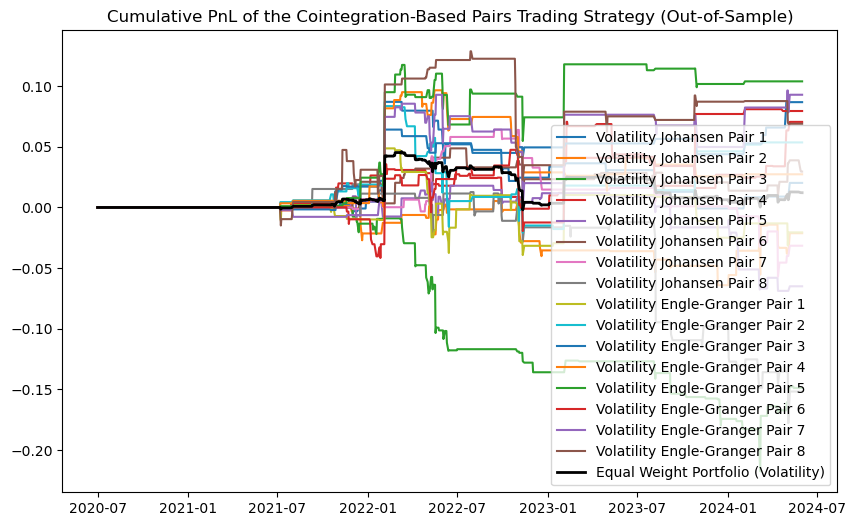

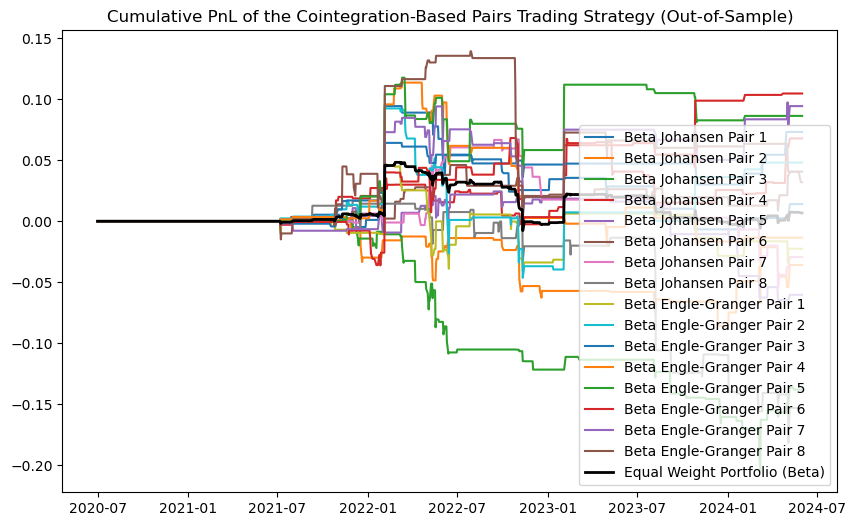

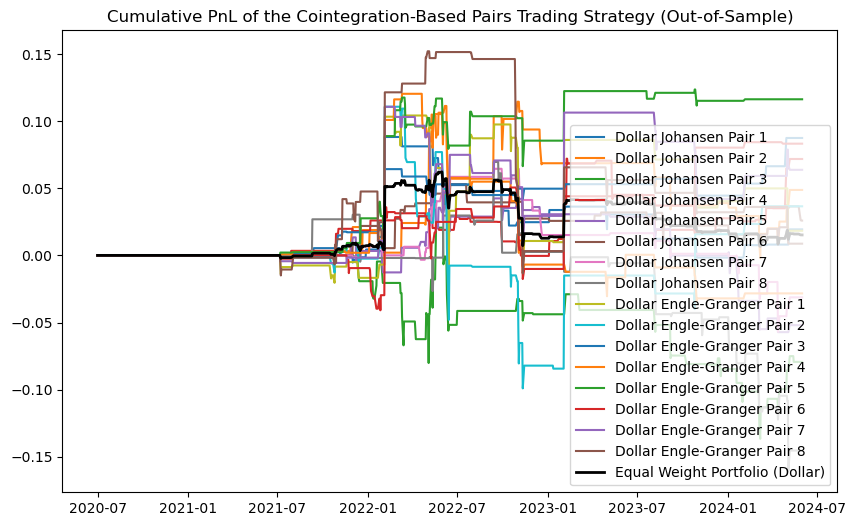

Cumulative PnL (Volatility Johansen Pair 1): 0.02
Cumulative PnL (Volatility Johansen Pair 2): -0.02
Cumulative PnL (Volatility Johansen Pair 3): -0.15
Cumulative PnL (Volatility Johansen Pair 4): 0.07
Cumulative PnL (Volatility Johansen Pair 5): -0.07
Cumulative PnL (Volatility Johansen Pair 6): 0.03
Cumulative PnL (Volatility Johansen Pair 7): -0.03
Cumulative PnL (Volatility Johansen Pair 8): -0.15
Cumulative PnL (Volatility Engle-Granger Pair 1): -0.02
Cumulative PnL (Volatility Engle-Granger Pair 2): 0.05
Cumulative PnL (Volatility Engle-Granger Pair 3): 0.09
Cumulative PnL (Volatility Engle-Granger Pair 4): 0.03
Cumulative PnL (Volatility Engle-Granger Pair 5): 0.10
Cumulative PnL (Volatility Engle-Granger Pair 6): 0.08
Cumulative PnL (Volatility Engle-Granger Pair 7): 0.09
Cumulative PnL (Volatility Engle-Granger Pair 8): 0.07
Cumulative PnL (Equal Weight Portfolio - Volatility): 0.01
Cumulative PnL (Beta Johansen Pair 1): 0.01
Cumulative PnL (Beta Johansen Pair 2): -0.04
Cumula

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
from itertools import combinations
import statsmodels.api as sm

# Define the tickers for demonstration (excluding S&P 500 index)
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
tickers = ["MSFT", "NVDA", "AAPL", "AMZN", "META", "GOOGL","AVGO", "LLY", "JPM", "XOM", "TSLA", "UNH", "V", "PG", "COST", "MA", "JNJ", "HD"]

start_date = '2013-01-01'
end_date = '2024-06-01'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(data).diff().dropna()
sp500_log_returns = np.log(sp500).diff().dropna()

# Normalize log returns
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Ensure no NaNs or infinite values
assert not normalized_log_returns.isnull().values.any(), "Log returns data contains NaN values"
assert np.isfinite(normalized_log_returns.values).all(), "Log returns data contains infinite values"

# Function to test cointegration for a pair using Johansen test
def johansen_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    johansen_test = coint_johansen(log_ret_pair, det_order=0, k_ar_diff=1)
    trace_statistic = johansen_test.lr1
    critical_values = johansen_test.cvt[:, 1]  # 5% critical values
    num_cointegrating_relations = sum(trace_statistic > critical_values)
    cointegration_vectors = johansen_test.evec if num_cointegrating_relations > 0 else None
    return num_cointegrating_relations, pair, cointegration_vectors

import pandas as pd
from statsmodels.tsa.stattools import coint

import pandas as pd
from statsmodels.tsa.stattools import coint

# Function to test cointegration for a pair using Engle-Granger test
import pandas as pd
from statsmodels.tsa.stattools import coint

# Function to test cointegration for a pair using Engle-Granger test
def engle_granger_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    score, pvalue, _ = coint(log_ret_pair.iloc[:, 0], log_ret_pair.iloc[:, 1])
    return pvalue, pair


    # Extract the two series from the data
    series1 = data[pair[0]]
    series2 = data[pair[1]]
    
    # Perform the Engle-Granger cointegration test
    score, pvalue, _ = coint(series1, series2)
    
    # Determine if we reject the null hypothesis of cointegration based on the significance level
    reject_cointegration = pvalue > significance_level
    
    return pvalue, reject_cointegration, pair






# Split the data into in-sample and out-of-sample
split_date = '2020-07-01'
in_sample_data = normalized_log_returns[:split_date]
out_sample_data = normalized_log_returns[split_date:]

# Get all possible pairs
pairs = list(combinations(in_sample_data.columns, 2))

# Test cointegration for all pairs using in-sample data
johansen_results = [johansen_cointegration_test(pair, in_sample_data) for pair in pairs]
engle_granger_results = [engle_granger_cointegration_test(pair, in_sample_data) for pair in pairs]

# Sort and select the top 3 pairs based on Johansen test
johansen_results.sort(reverse=True, key=lambda x: x[0])
top_pairs_johansen = johansen_results[:8]

# Sort and select the top 3 pairs based on Engle-Granger test
engle_granger_results.sort(key=lambda x: x[0])
top_pairs_engle_granger = engle_granger_results[:8]

# Output the selected pairs for each method
print("Top 8 pairs based on Johansen test:")
for i, pair in enumerate(top_pairs_johansen):
    print(f"Pair {i+1}: {pair[1]}")

print("\nTop 8 pairs based on Engle-Granger test:")
for i, pair in enumerate(top_pairs_engle_granger):
    print(f"Pair {i+1}: {pair[1]}")

# Function to calculate beta relative to a benchmark
def calculate_beta(stock_returns, benchmark_returns):
    X = sm.add_constant(stock_returns)
    model = sm.OLS(benchmark_returns, X).fit()
    return model.params[1]  # Beta coefficient

# Parameters for entry, exit, and stop-loss
entry_threshold = 2
exit_threshold = 0.5
stop_loss_threshold = 2.5

# Calculate the spreads, Z-scores, and positions for the top pairs
def calculate_spreads_and_positions(top_pairs, in_sample_data, out_sample_data, benchmark_returns, method):
    spreads = []
    z_scores = []
    positions_volatility = []
    positions_beta = []
    positions_dollar = []
    for result in top_pairs:
        if method == 'johansen':
            cointegration_vector = result[2][:, 0]
            spread = in_sample_data[result[1][0]] * cointegration_vector[0] - in_sample_data[result[1][1]] * cointegration_vector[1]
            spread_out_sample = out_sample_data[result[1][0]] * cointegration_vector[0] - out_sample_data[result[1][1]] * cointegration_vector[1]
        else:
            beta, _ = np.polyfit(in_sample_data[result[1][0]], in_sample_data[result[1][1]], 1)
            spread = in_sample_data[result[1][0]] - beta * in_sample_data[result[1][1]]
            spread_out_sample = out_sample_data[result[1][0]] - beta * out_sample_data[result[1][1]]

        spreads.append(spread)

        spread_mean = spread_out_sample.rolling(window=252).mean()
        spread_std = spread_out_sample.rolling(window=252).std()
        z_score = (spread_out_sample - spread_mean) / spread_std
        z_scores.append(z_score)

        # Calculate position sizes for volatility, beta, and dollar neutrality
        volatility_stock1 = in_sample_data[result[1][0]].std()
        volatility_stock2 = in_sample_data[result[1][1]].std()
        position_ratio_stock1_vol = 1 / volatility_stock1
        position_ratio_stock2_vol = 1 / volatility_stock2
        total_ratio_vol = position_ratio_stock1_vol + position_ratio_stock2_vol
        position_ratio_stock1_vol /= total_ratio_vol
        position_ratio_stock2_vol /= total_ratio_vol

        beta_stock1 = calculate_beta(log_returns[result[1][0]], benchmark_returns)
        beta_stock2 = calculate_beta(log_returns[result[1][1]], benchmark_returns)
        position_ratio_stock1_beta = 1 / beta_stock1
        position_ratio_stock2_beta = 1 / beta_stock2
        total_ratio_beta = position_ratio_stock1_beta + position_ratio_stock2_beta
        position_ratio_stock1_beta /= total_ratio_beta
        position_ratio_stock2_beta /= total_ratio_beta

        price_stock1 = data[result[1][0]].iloc[-1]  # Most recent price
        price_stock2 = data[result[1][1]].iloc[-1]  # Most recent price
        investment_amount = 10000  # Example investment amount per stock
        shares_stock1 = investment_amount / price_stock1
        shares_stock2 = investment_amount / price_stock2
        total_shares = shares_stock1 + shares_stock2
        position_ratio_stock1_dollar = shares_stock1 / total_shares
        position_ratio_stock2_dollar = shares_stock2 / total_shares

        def generate_positions(z_score, position_ratio_stock1, position_ratio_stock2):
            positions = []
            entry_dates = []
            exit_dates = []
            stop_loss_dates = []
            initial_entry_z_score = None
            for i in range(len(z_score)):
                if positions and any(positions[-1]):
                    if initial_entry_z_score is None:
                        initial_entry_z_score = z_score[i]
                    if abs(z_score[i] - initial_entry_z_score) >= stop_loss_threshold:
                        positions.append([0, 0])
                        initial_entry_z_score = None
                        stop_loss_dates.append(z_score.index[i])
                        continue
                
                if z_score[i] > entry_threshold:
                    positions.append([-position_ratio_stock1, position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif z_score[i] < -entry_threshold:
                    positions.append([position_ratio_stock1, -position_ratio_stock2])
                    entry_dates.append(z_score.index[i])
                    initial_entry_z_score = z_score[i]
                elif abs(z_score[i]) < exit_threshold:
                    positions.append([0, 0])
                    exit_dates.append(z_score.index[i])
                    initial_entry_z_score = None
                else:
                    positions.append(positions[-1] if positions else [0, 0])
            return positions, entry_dates, exit_dates, stop_loss_dates

        positions_volatility.append(generate_positions(z_score, position_ratio_stock1_vol, position_ratio_stock2_vol))
        positions_beta.append(generate_positions(z_score, position_ratio_stock1_beta, position_ratio_stock2_beta))
        positions_dollar.append(generate_positions(z_score, position_ratio_stock1_dollar, position_ratio_stock2_dollar))

    return spreads, z_scores, positions_volatility, positions_beta, positions_dollar

# Calculate spreads and positions for Johansen method
spreads_johansen, z_scores_johansen, positions_volatility_johansen, positions_beta_johansen, positions_dollar_johansen = calculate_spreads_and_positions(
    top_pairs_johansen, in_sample_data, out_sample_data, sp500_log_returns, method='johansen')

# Calculate spreads and positions for Engle-Granger method
spreads_engle_granger, z_scores_engle_granger, positions_volatility_engle_granger, positions_beta_engle_granger, positions_dollar_engle_granger = calculate_spreads_and_positions(
    top_pairs_engle_granger, in_sample_data, out_sample_data, sp500_log_returns, method='engle_granger')

# Convert positions to DataFrames and align indexes
positions_volatility_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_volatility_johansen, z_scores_johansen, top_pairs_johansen)]
positions_beta_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_beta_johansen, z_scores_johansen, top_pairs_johansen)]
positions_dollar_johansen_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_dollar_johansen, z_scores_johansen, top_pairs_johansen)]

positions_volatility_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_volatility_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]
positions_beta_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_beta_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]
positions_dollar_engle_granger_dfs = [pd.DataFrame(pos[0], columns=[pair[1][0], pair[1][1]], index=z_score.index).reindex(out_sample_data.index).fillna(0) for pos, z_score, pair in zip(positions_dollar_engle_granger, z_scores_engle_granger, top_pairs_engle_granger)]

# Calculate daily returns of the selected pairs
selected_pairs = [pair[1] for pair in top_pairs_johansen + top_pairs_engle_granger]
returns_out_sample = log_returns.loc[split_date:][list(set([item for sublist in selected_pairs for item in sublist]))].dropna()

# Calculate daily PnL for each method and each neutrality
def calculate_daily_pnl(positions_dfs, returns_out_sample, selected_pairs):
    daily_pnls = []
    for pos_df, pair in zip(positions_dfs, selected_pairs):
        daily_pnl = (pos_df.shift(1) * returns_out_sample[[pair[0], pair[1]]]).sum(axis=1)
        daily_pnls.append(daily_pnl)
    return daily_pnls

daily_pnls_volatility_johansen = calculate_daily_pnl(positions_volatility_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])
daily_pnls_beta_johansen = calculate_daily_pnl(positions_beta_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])
daily_pnls_dollar_johansen = calculate_daily_pnl(positions_dollar_johansen_dfs, returns_out_sample, [pair[1] for pair in top_pairs_johansen])

daily_pnls_volatility_engle_granger = calculate_daily_pnl(positions_volatility_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])
daily_pnls_beta_engle_granger = calculate_daily_pnl(positions_beta_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])
daily_pnls_dollar_engle_granger = calculate_daily_pnl(positions_dollar_engle_granger_dfs, returns_out_sample, [pair[1] for pair in top_pairs_engle_granger])

# Calculate cumulative PnL for each method and each neutrality
def calculate_cumulative_pnl(daily_pnls):
    return [daily_pnl.cumsum() for daily_pnl in daily_pnls]

cumulative_pnls_volatility_johansen = calculate_cumulative_pnl(daily_pnls_volatility_johansen)
cumulative_pnls_beta_johansen = calculate_cumulative_pnl(daily_pnls_beta_johansen)
cumulative_pnls_dollar_johansen = calculate_cumulative_pnl(daily_pnls_dollar_johansen)

cumulative_pnls_volatility_engle_granger = calculate_cumulative_pnl(daily_pnls_volatility_engle_granger)
cumulative_pnls_beta_engle_granger = calculate_cumulative_pnl(daily_pnls_beta_engle_granger)
cumulative_pnls_dollar_engle_granger = calculate_cumulative_pnl(daily_pnls_dollar_engle_granger)

# Calculate equal weight portfolio PnL
total_daily_pnl_volatility = sum(daily_pnls_volatility_johansen + daily_pnls_volatility_engle_granger) / len(daily_pnls_volatility_johansen + daily_pnls_volatility_engle_granger)
total_daily_pnl_beta = sum(daily_pnls_beta_johansen + daily_pnls_beta_engle_granger) / len(daily_pnls_beta_johansen + daily_pnls_beta_engle_granger)
total_daily_pnl_dollar = sum(daily_pnls_dollar_johansen + daily_pnls_dollar_engle_granger) / len(daily_pnls_dollar_johansen + daily_pnls_dollar_engle_granger)

cumulative_pnl_portfolio_volatility = total_daily_pnl_volatility.cumsum()
cumulative_pnl_portfolio_beta = total_daily_pnl_beta.cumsum()
cumulative_pnl_portfolio_dollar = total_daily_pnl_dollar.cumsum()

# Plot cumulative PnL for each method and the portfolio
plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_volatility_johansen):
    plt.plot(cumulative_pnl, label=f'Volatility Johansen Pair {i+1}')
for i, cumulative_pnl in enumerate(cumulative_pnls_volatility_engle_granger):
    plt.plot(cumulative_pnl, label=f'Volatility Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_volatility, label='Equal Weight Portfolio (Volatility)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_beta_johansen):
    plt.plot(cumulative_pnl, label=f'Beta Johansen Pair {i+1}')
for i, cumulative_pnl in enumerate(cumulative_pnls_beta_engle_granger):
    plt.plot(cumulative_pnl, label=f'Beta Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_beta, label='Equal Weight Portfolio (Beta)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i, cumulative_pnl in enumerate(cumulative_pnls_dollar_johansen):
    plt.plot(cumulative_pnl, label=f'Dollar Johansen Pair {i+1}')
for i, cumulative_pnl in enumerate(cumulative_pnls_dollar_engle_granger):
    plt.plot(cumulative_pnl, label=f'Dollar Engle-Granger Pair {i+1}')
plt.plot(cumulative_pnl_portfolio_dollar, label='Equal Weight Portfolio (Dollar)', linewidth=2, color='black')
plt.title('Cumulative PnL of the Cointegration-Based Pairs Trading Strategy (Out-of-Sample)')
plt.legend()
plt.show()

# Print cumulative PnL for each method and the portfolio
def print_cumulative_pnls(cumulative_pnls, method):
    for i, cumulative_pnl in enumerate(cumulative_pnls):
        print(f"Cumulative PnL ({method} Pair {i+1}): {cumulative_pnl.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_volatility_johansen, 'Volatility Johansen')
print_cumulative_pnls(cumulative_pnls_volatility_engle_granger, 'Volatility Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Volatility): {cumulative_pnl_portfolio_volatility.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_beta_johansen, 'Beta Johansen')
print_cumulative_pnls(cumulative_pnls_beta_engle_granger, 'Beta Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Beta): {cumulative_pnl_portfolio_beta.iloc[-1]:.2f}")

print_cumulative_pnls(cumulative_pnls_dollar_johansen, 'Dollar Johansen')
print_cumulative_pnls(cumulative_pnls_dollar_engle_granger, 'Dollar Engle-Granger')
print(f"Cumulative PnL (Equal Weight Portfolio - Dollar): {cumulative_pnl_portfolio_dollar.iloc[-1]:.2f}")

# Print strategy performance metrics for each method
def print_performance_metrics(cumulative_pnl, daily_pnl):
    total_return = cumulative_pnl.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(cumulative_pnl)) - 1  # Assuming 252 trading days in a year
    annualized_volatility = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_volatility_johansen, daily_pnls_volatility_johansen)):
    print(f"Performance Metrics (Volatility Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_volatility_engle_granger, daily_pnls_volatility_engle_granger)):
    print(f"Performance Metrics (Volatility Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Volatility):")
print_performance_metrics(cumulative_pnl_portfolio_volatility, total_daily_pnl_volatility)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_beta_johansen, daily_pnls_beta_johansen)):
    print(f"Performance Metrics (Beta Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_beta_engle_granger, daily_pnls_beta_engle_granger)):
    print(f"Performance Metrics (Beta Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Beta):")
print_performance_metrics(cumulative_pnl_portfolio_beta, total_daily_pnl_beta)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_dollar_johansen, daily_pnls_dollar_johansen)):
    print(f"Performance Metrics (Dollar Johansen Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

for i, (cumulative_pnl, daily_pnl) in enumerate(zip(cumulative_pnls_dollar_engle_granger, daily_pnls_dollar_engle_granger)):
    print(f"Performance Metrics (Dollar Engle-Granger Pair {i+1}):")
    print_performance_metrics(cumulative_pnl, daily_pnl)

print("Performance Metrics (Equal Weight Portfolio - Dollar):")
print_performance_metrics(cumulative_pnl_portfolio_dollar, total_daily_pnl_dollar)


[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


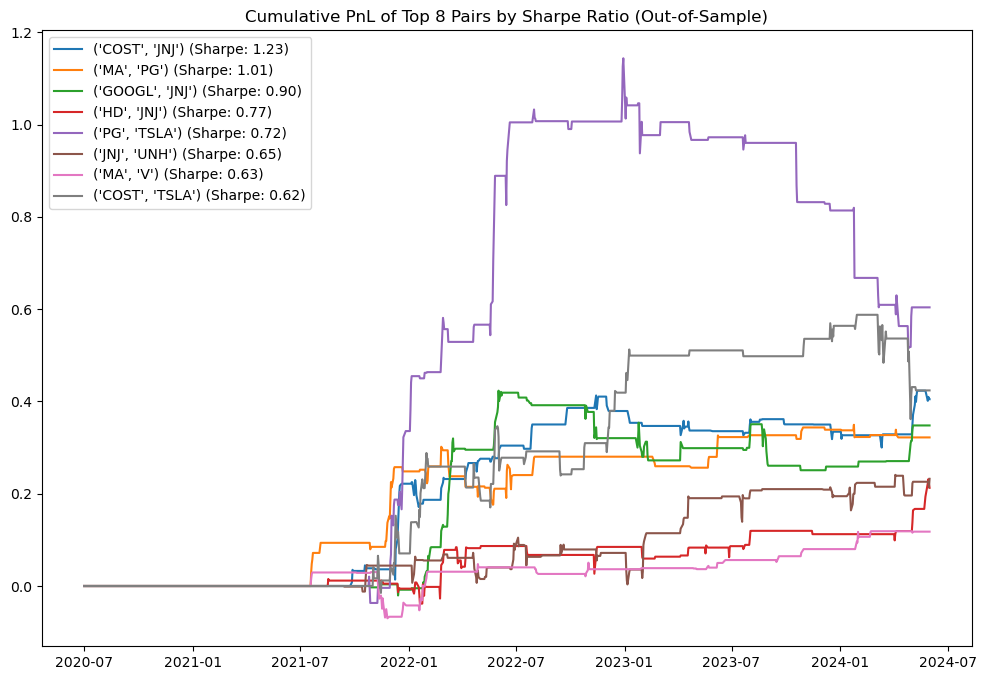

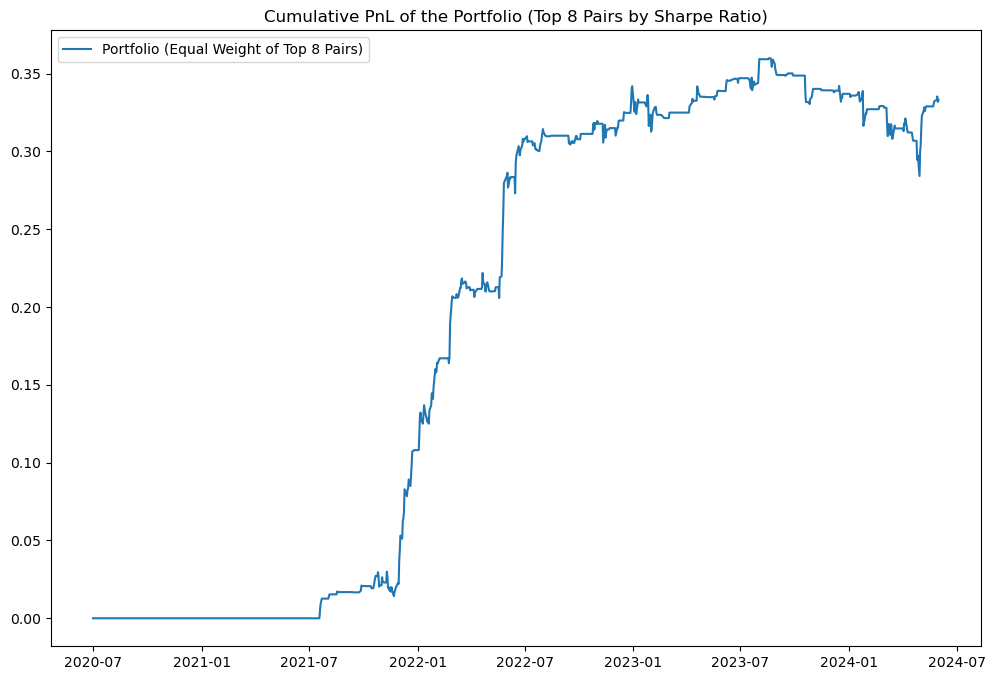

Top 8 Pairs by Sharpe Ratio:
Pair: ('COST', 'JNJ'), Sharpe Ratio: 1.23
Pair: ('MA', 'PG'), Sharpe Ratio: 1.01
Pair: ('GOOGL', 'JNJ'), Sharpe Ratio: 0.90
Pair: ('HD', 'JNJ'), Sharpe Ratio: 0.77
Pair: ('PG', 'TSLA'), Sharpe Ratio: 0.72
Pair: ('JNJ', 'UNH'), Sharpe Ratio: 0.65
Pair: ('MA', 'V'), Sharpe Ratio: 0.63
Pair: ('COST', 'TSLA'), Sharpe Ratio: 0.62

Portfolio Sharpe Ratio: 1.71


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
from itertools import combinations
import statsmodels.api as sm

# Define the tickers for demonstration (excluding S&P 500 index)
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
tickers = ["MSFT", "NVDA", "AAPL", "AMZN", "META", "GOOGL","AVGO", "LLY", "JPM", "XOM", "TSLA", "UNH", "V", "PG", "COST", "MA", "JNJ", "HD"]

start_date = '2013-01-01'
end_date = '2024-06-01'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(data).diff().dropna()
sp500_log_returns = np.log(sp500).diff().dropna()

# Normalize log returns
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Function to test cointegration for a pair using Johansen test
def johansen_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    johansen_test = coint_johansen(log_ret_pair, det_order=0, k_ar_diff=1)
    trace_statistic = johansen_test.lr1
    critical_values = johansen_test.cvt[:, 1]  # 5% critical values
    num_cointegrating_relations = sum(trace_statistic > critical_values)
    cointegration_vectors = johansen_test.evec if num_cointegrating_relations > 0 else None
    return num_cointegrating_relations, pair, cointegration_vectors

# Function to test cointegration for a pair using Engle-Granger test
def engle_granger_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    score, pvalue, _ = coint(log_ret_pair.iloc[:, 0], log_ret_pair.iloc[:, 1])
    return pvalue, pair

# Split the data into in-sample and out-of-sample
split_date = '2020-07-01'
in_sample_data = normalized_log_returns[:split_date]
out_sample_data = normalized_log_returns[split_date:]

# Get all possible pairs
pairs = list(combinations(in_sample_data.columns, 2))

# Test cointegration for all pairs using in-sample data
johansen_results = [johansen_cointegration_test(pair, in_sample_data) for pair in pairs]
engle_granger_results = [engle_granger_cointegration_test(pair, in_sample_data) for pair in pairs]

# Combine the pairs and remove duplicates
pairs_johansen = [result[1] for result in johansen_results if result[0] > 0]  # Only keep pairs with at least 1 cointegrating relation
pairs_engle_granger = [result[1] for result in engle_granger_results if result[0] < 0.05]  # Only keep pairs with p-value < 0.05
combined_pairs = list(set(pairs_johansen + pairs_engle_granger))

# Function to calculate beta relative to a benchmark
def calculate_beta(stock_returns, benchmark_returns):
    X = sm.add_constant(stock_returns)
    model = sm.OLS(benchmark_returns, X).fit()
    return model.params[1]  # Beta coefficient

# Parameters for entry, exit, and stop-loss
entry_threshold = 2
exit_threshold = 0.5
stop_loss_threshold = 3

# Calculate the spreads, Z-scores, and positions for the selected pairs
def calculate_spreads_and_positions(pair, in_sample_data, out_sample_data):
    spread = in_sample_data[pair[0]] - in_sample_data[pair[1]]
    spread_out_sample = out_sample_data[pair[0]] - out_sample_data[pair[1]]
    spread_mean = spread_out_sample.rolling(window=252).mean()
    spread_std = spread_out_sample.rolling(window=252).std()
    z_score = (spread_out_sample - spread_mean) / spread_std

    positions = []
    for i in range(len(z_score)):
        if z_score[i] > entry_threshold:
            positions.append([-1, 1])  # Short first, long second
        elif z_score[i] < -entry_threshold:
            positions.append([1, -1])  # Long first, short second
        elif abs(z_score[i]) < exit_threshold:
            positions.append([0, 0])  # Exit positions
        else:
            positions.append(positions[-1] if positions else [0, 0])
    
    positions_df = pd.DataFrame(positions, index=z_score.index, columns=[pair[0], pair[1]])
    return spread, z_score, positions_df

# Calculate Sharpe ratio
def calculate_sharpe_ratio(daily_pnl):
    total_return = daily_pnl.sum()
    annualized_return = total_return * (252 / len(daily_pnl))  # Assuming 252 trading days in a year
    annualized_volatility = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    return sharpe_ratio

# Evaluate all combined pairs and select top 3 by Sharpe ratio
sharpe_ratios = []
daily_pnls = []
for pair in combined_pairs:
    spread, z_score, positions_df = calculate_spreads_and_positions(pair, in_sample_data, out_sample_data)
    daily_pnl = (positions_df.shift(1) * log_returns.loc[split_date:][[pair[0], pair[1]]]).sum(axis=1)
    sharpe_ratio = calculate_sharpe_ratio(daily_pnl)
    sharpe_ratios.append((sharpe_ratio, pair, daily_pnl))
    daily_pnls.append(daily_pnl)

# Sort by Sharpe ratio and select top 3 pairs
sharpe_ratios.sort(reverse=True, key=lambda x: x[0])
top_8_pairs = sharpe_ratios[:8]

# Plot individual performances
plt.figure(figsize=(12, 8))
for sharpe, pair, daily_pnl in top_8_pairs:
    cumulative_pnl = daily_pnl.cumsum()
    plt.plot(cumulative_pnl, label=f'{pair} (Sharpe: {sharpe:.2f})')
plt.title('Cumulative PnL of Top 8 Pairs by Sharpe Ratio (Out-of-Sample)')
plt.legend()
plt.show()

# Combine top 3 pairs into a single portfolio
portfolio_daily_pnl = sum([pnl for _, _, pnl in top_8_pairs]) / 8
portfolio_cumulative_pnl = portfolio_daily_pnl.cumsum()

# Plot portfolio performance
plt.figure(figsize=(12, 8))
plt.plot(portfolio_cumulative_pnl, label='Portfolio (Equal Weight of Top 8 Pairs)')
plt.title('Cumulative PnL of the Portfolio (Top 8 Pairs by Sharpe Ratio)')
plt.legend()
plt.show()

# Print Sharpe ratios of top 3 pairs and portfolio
print("Top 8 Pairs by Sharpe Ratio:")
for sharpe, pair, _ in top_8_pairs:
    print(f"Pair: {pair}, Sharpe Ratio: {sharpe:.2f}")

portfolio_sharpe_ratio = calculate_sharpe_ratio(portfolio_daily_pnl)
print(f"\nPortfolio Sharpe Ratio: {portfolio_sharpe_ratio:.2f}")


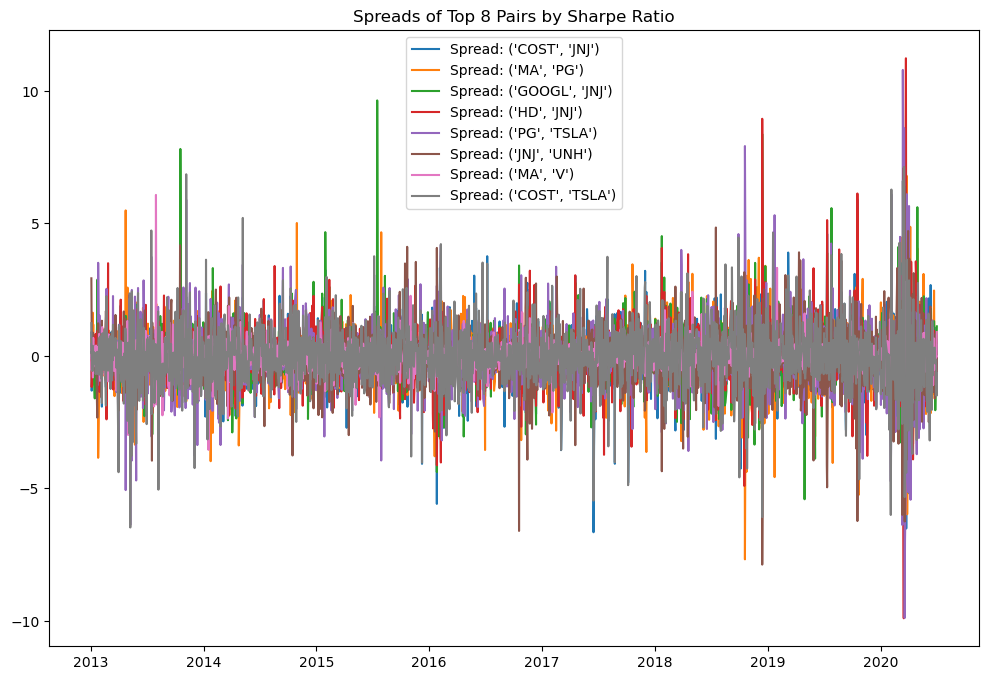

In [13]:
# Plot spreads for the top 3 pairs
plt.figure(figsize=(12, 8))
for _, pair, _ in top_8_pairs:
    spread, z_score, _ = calculate_spreads_and_positions(pair, in_sample_data, out_sample_data)
    plt.plot(spread, label=f'Spread: {pair}')
plt.title('Spreads of Top 8 Pairs by Sharpe Ratio')
plt.legend()
plt.show()


In [14]:
# Print performance metrics for Johansen and Engle-Granger pairs
print("Performance Metrics for Johansen Test Pairs:")
for sharpe, pair, pnl in sharpe_ratios[:3]:
    total_return = pnl.sum()
    annualized_return = total_return * (252 / len(pnl))
    annualized_volatility = pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    print(f"Pair: {pair}, Total Return: {total_return:.2f}, Annualized Return: {annualized_return:.2f}, Annualized Volatility: {annualized_volatility:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nPerformance Metrics for Engle-Granger Test Pairs:")
for sharpe, pair, pnl in sharpe_ratios[3:]:
    total_return = pnl.sum()
    annualized_return = total_return * (252 / len(pnl))
    annualized_volatility = pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    print(f"Pair: {pair}, Total Return: {total_return:.2f}, Annualized Return: {annualized_return:.2f}, Annualized Volatility: {annualized_volatility:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}")


print("\nPerformance Metrics for Portfolio (Top 8 Pairs):")
total_return = portfolio_daily_pnl.sum()
annualized_return = total_return * (252 / len(portfolio_daily_pnl))
annualized_volatility = portfolio_daily_pnl.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility
print(f"Total Return: {total_return:.2f}, Annualized Return: {annualized_return:.2f}, Annualized Volatility: {annualized_volatility:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}")


Performance Metrics for Johansen Test Pairs:
Pair: ('COST', 'JNJ'), Total Return: 0.40, Annualized Return: 0.10, Annualized Volatility: 0.08, Sharpe Ratio: 1.23
Pair: ('MA', 'PG'), Total Return: 0.32, Annualized Return: 0.08, Annualized Volatility: 0.08, Sharpe Ratio: 1.01
Pair: ('GOOGL', 'JNJ'), Total Return: 0.35, Annualized Return: 0.09, Annualized Volatility: 0.10, Sharpe Ratio: 0.90

Performance Metrics for Engle-Granger Test Pairs:
Pair: ('HD', 'JNJ'), Total Return: 0.21, Annualized Return: 0.05, Annualized Volatility: 0.07, Sharpe Ratio: 0.77
Pair: ('PG', 'TSLA'), Total Return: 0.60, Annualized Return: 0.15, Annualized Volatility: 0.22, Sharpe Ratio: 0.72
Pair: ('JNJ', 'UNH'), Total Return: 0.23, Annualized Return: 0.06, Annualized Volatility: 0.09, Sharpe Ratio: 0.65
Pair: ('MA', 'V'), Total Return: 0.12, Annualized Return: 0.03, Annualized Volatility: 0.05, Sharpe Ratio: 0.63
Pair: ('COST', 'TSLA'), Total Return: 0.42, Annualized Return: 0.11, Annualized Volatility: 0.18, Shar

In [15]:
# Define the transaction cost per trade as a percentage of the traded value
transaction_cost_rate = 0.001  # 0.1% per trade


In [16]:
# Calculate the spreads, Z-scores, and positions for the selected pairs, including transaction costs
def calculate_spreads_and_positions(pair, in_sample_data, out_sample_data):
    spread = in_sample_data[pair[0]] - in_sample_data[pair[1]]
    spread_out_sample = out_sample_data[pair[0]] - out_sample_data[pair[1]]
    spread_mean = spread_out_sample.rolling(window=252).mean()
    spread_std = spread_out_sample.rolling(window=252).std()
    z_score = (spread_out_sample - spread_mean) / spread_std

    positions = []
    for i in range(len(z_score)):
        if z_score[i] > entry_threshold:
            positions.append([-1, 1])  # Short first, long second
        elif z_score[i] < -entry_threshold:
            positions.append([1, -1])  # Long first, short second
        elif abs(z_score[i]) < exit_threshold:
            positions.append([0, 0])  # Exit positions
        else:
            positions.append(positions[-1] if positions else [0, 0])
    
    positions_df = pd.DataFrame(positions, index=z_score.index, columns=[pair[0], pair[1]])
    return spread, z_score, positions_df


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
from itertools import combinations
import statsmodels.api as sm

# Define the tickers for demonstration (excluding S&P 500 index)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2013-01-01'
end_date = '2024-06-01'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data.dropna(inplace=True)

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(data).diff().dropna()
sp500_log_returns = np.log(sp500).diff().dropna()

# Normalize log returns
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Function to test cointegration for a pair using Johansen test
def johansen_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    johansen_test = coint_johansen(log_ret_pair, det_order=0, k_ar_diff=1)
    trace_statistic = johansen_test.lr1
    critical_values = johansen_test.cvt[:, 1]  # 5% critical values
    num_cointegrating_relations = sum(trace_statistic > critical_values)
    cointegration_vectors = johansen_test.evec if num_cointegrating_relations > 0 else None
    return num_cointegrating_relations, pair, cointegration_vectors

# Function to test cointegration for a pair using Engle-Granger test
def engle_granger_cointegration_test(pair, data):
    log_ret_pair = data[list(pair)]
    score, pvalue, _ = coint(log_ret_pair.iloc[:, 0], log_ret_pair.iloc[:, 1])
    return pvalue, pair

# Split the data into in-sample and out-of-sample
split_date = '2020-07-01'
in_sample_data = normalized_log_returns[:split_date]
out_sample_data = normalized_log_returns[split_date:]

# Get all possible pairs
pairs = list(combinations(in_sample_data.columns, 2))

# Test cointegration for all pairs using in-sample data
johansen_results = [johansen_cointegration_test(pair, in_sample_data) for pair in pairs]
engle_granger_results = [engle_granger_cointegration_test(pair, in_sample_data) for pair in pairs]

# Combine the pairs and remove duplicates
pairs_johansen = [result[1] for result in johansen_results if result[0] > 0]  # Only keep pairs with at least 1 cointegrating relation
pairs_engle_granger = [result[1] for result in engle_granger_results if result[0] < 0.05]  # Only keep pairs with p-value < 0.05
combined_pairs = list(set(pairs_johansen + pairs_engle_granger))

# Define the transaction cost per trade as a percentage of the traded value
transaction_cost_rate = 0.001  # 0.1% per trade

# Parameters for entry, exit, and stop-loss
entry_threshold = 2
exit_threshold = 0.5
stop_loss_threshold = 3

# Calculate the spreads, Z-scores, and positions for the selected pairs, including transaction costs
def calculate_spreads_and_positions(pair, in_sample_data, out_sample_data):
    spread = in_sample_data[pair[0]] - in_sample_data[pair[1]]
    spread_out_sample = out_sample_data[pair[0]] - out_sample_data[pair[1]]
    spread_mean = spread_out_sample.rolling(window=252).mean()
    spread_std = spread_out_sample.rolling(window=252).std()
    z_score = (spread_out_sample - spread_mean) / spread_std

    positions = []
    for i in range(len(z_score)):
        if z_score[i] > entry_threshold:
            positions.append([-1, 1])  # Short first, long second
        elif z_score[i] < -entry_threshold:
            positions.append([1, -1])  # Long first, short second
        elif abs(z_score[i]) < exit_threshold:
            positions.append([0, 0])  # Exit positions
        else:
            positions.append(positions[-1] if positions else [0, 0])
    
    positions_df = pd.DataFrame(positions, index=z_score.index, columns=[pair[0], pair[1]])
    return spread, z_score, positions_df

# Calculate Sharpe ratio, including transaction costs
def calculate_sharpe_ratio(daily_pnl):
    total_return = daily_pnl.sum()
    annualized_return = total_return * (252 / len(daily_pnl))  # Assuming 252 trading days in a year
    annualized_volatility = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    return sharpe_ratio

# Evaluate all combined pairs and select top 3 by Sharpe ratio, including transaction costs
sharpe_ratios = []
daily_pnls = []
for pair in combined_pairs:
    spread, z_score, positions_df = calculate_spreads_and_positions(pair, in_sample_data, out_sample_data)
    daily_pnl = (positions_df.shift(1) * log_returns.loc[split_date:][[pair[0], pair[1]]]).sum(axis=1)
    
    # Calculate transaction costs
    transaction_costs = transaction_cost_rate * positions_df.diff().abs().sum(axis=1)
    daily_pnl -= transaction_costs
    
    sharpe_ratio = calculate_sharpe_ratio(daily_pnl)
    sharpe_ratios.append((sharpe_ratio, pair, daily_pnl))
    daily_pnls.append(daily_pnl)

# Sort by Sharpe ratio and select top 3 pairs
sharpe_ratios.sort(reverse=True, key=lambda x: x[0])
top_3_pairs = sharpe_ratios[:3]

# Combine top 3 pairs into a single portfolio
portfolio_daily_pnl = sum([pnl for _, _, pnl in top_3_pairs]) / 3
portfolio_cumulative_pnl = portfolio_daily_pnl.cumsum()

# Plot portfolio performance with transaction costs
plt.figure(figsize=(12, 8))
plt.plot(portfolio_cumulative_pnl, label='Portfolio (Equal Weight of Top 3 Pairs)')
plt.title('Cumulative PnL of the Portfolio (Top 3 Pairs by Sharpe Ratio)')
plt.legend()
plt.show()
